# Kaggle Playground 

### Problem Statement / Real World Implementations

### 1. Importing Libraries

In [1]:
# Core Data Science Libraries
import numpy as np
import pandas as pd
import warnings

# Visualization Libraries
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn for Preprocessing and Modeling
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine Learning Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Hyperparameter Tuning
import optuna

# Notebook settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### 2. Loading Dataset

In [2]:
# Define file paths
TRAIN_PATH = "/kaggle/input/playground-series-s5e11/train.csv"
TEST_PATH = "/kaggle/input/playground-series-s5e11/test.csv"
SUBMISSION_PATH = "/kaggle/input/playground-series-s5e11/sample_submission.csv"

# Load the datasets into pandas DataFrames
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
submission_df = pd.read_csv(SUBMISSION_PATH)

In [3]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (593994, 13)
Test shape: (254569, 12)


In [4]:
df=train_df
df.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [5]:
print(df["gender"].unique())
print(df["marital_status"].unique())
print(df["education_level"].unique())
print(df["employment_status"].unique())
print(df["loan_purpose"].unique())
print(df["grade_subgrade"].unique())

['Female' 'Male' 'Other']
['Single' 'Married' 'Divorced' 'Widowed']
['High School' "Master's" "Bachelor's" 'PhD' 'Other']
['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


In [6]:
df.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [7]:
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


### 4. EDA

In [8]:
# Select only numeric columns for correlation matrix
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('id')
numerical_cols.remove('loan_paid_back')

numeric_df = train_df[numerical_cols + ['loan_paid_back']]
corr_matrix = numeric_df.corr()

# Create the interactive heatmap
fig = go.Figure(data=go.Heatmap(
                   z=corr_matrix.values,
                   x=corr_matrix.columns,
                   y=corr_matrix.columns,
                   colorscale='RdBu_r',
                   zmin=-1, zmax=1,
                   text=corr_matrix.round(2).values,
                   texttemplate="%{text}",
                   hoverongaps=False))

fig.update_layout(
    title='Correlation Heatmap of Numerical Features',
    width=800, height=800
)
fig.show()

### 3. Normalization of data

In [9]:
# Save the test IDs now, before we drop the 'id' column
test_ids = test_df['id']
# ---------------------

# Drop 'id' from both, as it's not a feature
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [10]:
def create_financial_features(df):
    """
    Creates new financial features from the existing columns.
    """
    # Create monthly_income
    df['monthly_income'] = df['annual_income'] / 12
    
    # Create total_monthly_debt
    df['total_monthly_debt'] = df['debt_to_income_ratio'] * df['monthly_income']
    
    # Create available_income (disposable income)
    df['available_income'] = df['monthly_income'] - df['total_monthly_debt']
    
    # Create loan_to_income_ratio
    df['loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']
    
    # Create loan_to_available_income
    df['loan_to_available_income'] = df['loan_amount'] / df['available_income']
    
    # Clean up any 'inf' values created by dividing by zero
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop the original, redundant columns
    cols_to_drop = ['annual_income', 'debt_to_income_ratio']
    df = df.drop(columns=cols_to_drop)
    
    return df

print("Creating financial features for train_df...")
train_df = create_financial_features(train_df)
print("Creating financial features for test_df...")
test_df = create_financial_features(test_df)

Creating financial features for train_df...
Creating financial features for test_df...


In [11]:
def process_and_encode_features(df_train, df_test):
    """
    Applies binning, logical ordinal mapping, and 
    ordinal encoding to both train and test sets.
    
    *** CORRECTED VERSION: Does NOT fill NaNs ***
    """
    # Save target and combine for consistent processing
    train_target = df_train['loan_paid_back']
    df_train = df_train.drop('loan_paid_back', axis=1)
    
    df_train['source'] = 'train'
    df_test['source'] = 'test'
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    
    # --- 1. Bin Credit Score ---
    score_bins = [300, 579, 669, 739, 799, 850]
    score_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
    combined_df['credit_score_bin'] = pd.cut(combined_df['credit_score'], 
                                             bins=score_bins, 
                                             labels=score_labels, 
                                             include_lowest=True)
    
    # --- 2. Logical Ordinal Mapping ---
    education_map = {
        'Other': 0, 'High School': 1, 'Bachelor\'s': 2, 'Master\'s': 3, 'PhD': 4
    }
    grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    subgrades = ['1', '2', '3', '4', '5']
    grade_map = {g + s: i for i, (g, s) in enumerate((g, s) for g in grades for s in subgrades)}

    combined_df['education_level_ordinal'] = combined_df['education_level'].map(education_map)
    combined_df['grade_subgrade_ordinal'] = combined_df['grade_subgrade'].map(grade_map)

    # --- 3. Ordinal Encode Remaining Categoricals ---
    categorical_cols = [
        'gender', 'marital_status', 'employment_status', 
        'loan_purpose', 'credit_score_bin'
    ]
    
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    combined_df['credit_score_bin'] = combined_df['credit_score_bin'].astype(str)
    combined_df[categorical_cols] = encoder.fit_transform(combined_df[categorical_cols])

    # --- 4. HANDLE NaNs ---
    # We will let the tree models handle NaNs in 'loan_to_available_income'
    # But we should still fill 'education_level_ordinal' as it's an encoding
    if combined_df['education_level_ordinal'].isnull().any():
        mode_val = combined_df['education_level_ordinal'].mode()[0]
        combined_df['education_level_ordinal'] = combined_df['education_level_ordinal'].fillna(mode_val)
            
    # --- 5. Drop old columns and split back ---
    cols_to_drop = ['credit_score', 'education_level', 'grade_subgrade']
    combined_df = combined_df.drop(columns=cols_to_drop)
    
    train_processed = combined_df[combined_df['source'] == 'train'].drop('source', axis=1)
    test_processed = combined_df[combined_df['source'] == 'test'].drop('source', axis=1)
    
    # Add target back
    train_processed['loan_paid_back'] = train_target
    
    return train_processed, test_processed

# --- Re-run the processing ---
print("Processing and encoding all features (letting trees handle NaNs)...")
train_processed, test_processed = process_and_encode_features(train_df, test_df)
print("Processing complete.")

Processing and encoding all features (letting trees handle NaNs)...
Processing complete.


In [12]:
df.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


Summary Statistics:



,loan_amount,interest_rate,gender,marital_status,employment_status,loan_purpose,monthly_income,total_monthly_debt,available_income,loan_to_income_ratio,loan_to_available_income,credit_score_bin,education_level_ordinal,grade_subgrade_ordinal
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,15020.297629,12.356345,0.490825,1.472616,0.685438,2.609976,4017.683581,485.002319,3532.681262,0.427574,5.875664,1.899464,1.794939,13.967705
std,6926.530568,2.008959,0.512317,0.585860,1.332355,1.656488,2225.995173,415.297292,1979.316733,0.366041,5.081131,0.967466,0.823183,5.115538
min,500.090000,3.200000,0.000000,0.000000,0.000000,0.000000,500.202500,7.014620,274.692110,0.002491,0.032883,0.000000,0.000000,0.000000
25%,10279.620000,10.990000,0.000000,1.000000,0.000000,2.000000,2327.866667,216.130683,2037.879680,0.194734,2.653587,1.000000,1.000000,11.000000
50%,15000.220000,12.370000,0.000000,1.000000,0.000000,2.000000,3879.806667,367.691262,3386.199475,0.322538,4.406622,2.000000,2.000000,13.000000
75%,18858.580000,13.680000,1.000000,2.000000,0.000000,3.000000,5081.776667,615.139751,4450.237361,0.536990,7.385818,2.000000,2.000000,17.000000
max,48959.950000,20.990000,2.000000,3.000000,4.000000,7.000000,32781.811667,11151.413863,31477.877736,5.461143,94.091476,4.000000,4.000000,29.000000



Feature Ranges:

loan_amount                 48459.860000
monthly_income              32281.609167
available_income            31203.185626
total_monthly_debt          11144.399243
loan_to_available_income       94.058593
grade_subgrade_ordinal         29.000000
interest_rate                  17.790000
loan_purpose                    7.000000
loan_to_income_ratio            5.458652
employment_status               4.000000
credit_score_bin                4.000000
education_level_ordinal         4.000000
marital_status                  3.000000
gender                          2.000000
dtype: float64


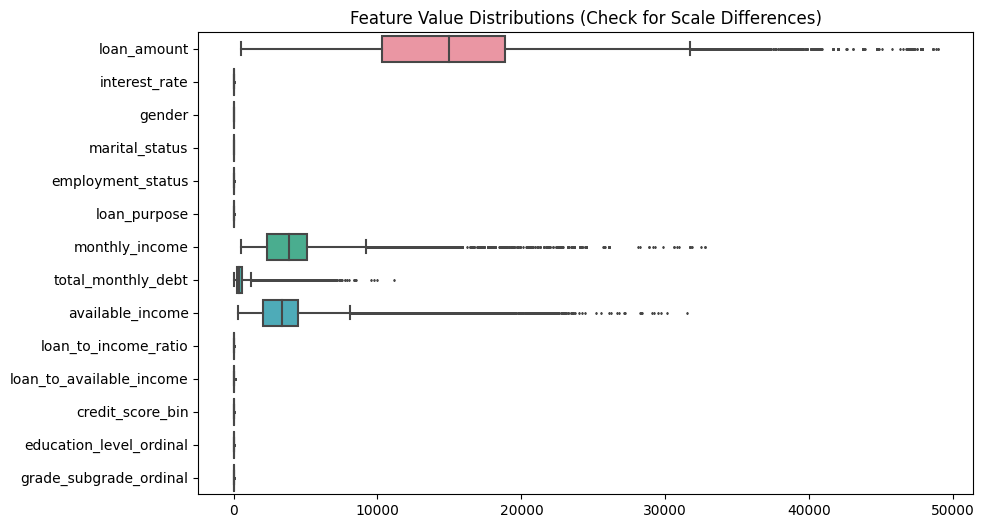


Features with significantly higher ranges: ['loan_amount', 'monthly_income', 'total_monthly_debt', 'available_income']

✅ Feature scaling is likely necessary (large scale differences detected).


In [13]:
# Exclude target column if present
features = train_processed.drop(columns=['loan_paid_back'], errors='ignore')

# 1. Check summary statistics
print("Summary Statistics:\n")
display(features.describe())

# 2. Check for large differences in scale
range_df = features.max() - features.min()
print("\nFeature Ranges:\n")
print(range_df.sort_values(ascending=False))

# 3. Visualize distribution of feature scales
plt.figure(figsize=(10, 6))
sns.boxplot(data=features, orient='h', fliersize=1)
plt.title("Feature Value Distributions (Check for Scale Differences)")
plt.show()

# 4. Correlation check
corr_matrix = features.corr()
high_range_features = range_df[range_df > range_df.mean()].index.tolist()
print(f"\nFeatures with significantly higher ranges: {high_range_features}")

# 5. Quick rule-based decision
if range_df.max() / range_df.min() > 10:
    print("\n✅ Feature scaling is likely necessary (large scale differences detected).")
else:
    print("\n❌ Feature scaling might not be strictly necessary (features on similar scales).")

### Train test split

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
import numpy as np

# Use encoded data for model training
X = train_processed.drop("loan_paid_back", axis=1)
y = train_processed["loan_paid_back"]

# Ensure all columns are numeric
X = X.select_dtypes(include=[np.number])

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Choose scaling method
selected_method = 'Standard Scaling'
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ✅ Enable GPU for both XGBoost and LightGBM

# --- Hyperparameter tuning for XGBRegressor ---
def objective_xgb(trial):
    param = {
        'tree_method': 'gpu_hist',     # Use GPU histogram algorithm
        'predictor': 'gpu_predictor',  # GPU prediction
        'gpu_id': 0,
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.5, 0.7, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state': 42
    }

    model = XGBRegressor(**param, verbosity=0)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    return mse


# --- Hyperparameter tuning for LGBMRegressor ---
def objective_lgbm(trial):
    param = {
        'device': 'gpu',                # GPU acceleration
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mse',

        # Regularization (not too extreme)
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 1.0, log=True),

        # Tree and data sampling
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),

        # Learning control
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),

        'random_state': 42,
        'verbosity': -1
    }

    model = LGBMRegressor(**param)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# --- Run GPU-accelerated Optuna optimization ---
print("🚀 Tuning XGBRegressor (GPU)...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=150, timeout=7200)
best_params_xgb = study_xgb.best_params
print(f"✅ Best XGBRegressor parameters: {best_params_xgb}")

print("\n🚀 Tuning LGBMRegressor (GPU)...")
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=150, timeout=7200)
best_params_lgbm = study_lgbm.best_params
print(f"✅ Best LGBMRegressor parameters: {best_params_lgbm}")


# --- Initialize models with tuned GPU parameters ---
xgb_model = XGBRegressor(**best_params_xgb, tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)
lgbm_model = LGBMRegressor(**best_params_lgbm, device='gpu')

models = [
    ("XGBRegressor (GPU)", xgb_model),
    ("LGBMRegressor (GPU)", lgbm_model)
]

print("\n⚡ Evaluating Tuned Models on GPU...\n")
mse_scores = []
model_names = []

for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    model_names.append(name)

    print(f"{name:<30} | MSE: {mse:.5f} | MAE: {mae:.5f} | R²: {r2:.5f}")

[I 2025-11-03 11:43:52,593] A new study created in memory with name: no-name-ff77064b-bc08-43b9-af19-798a2a82345a


🚀 Tuning XGBRegressor (GPU)...


[I 2025-11-03 11:43:57,913] Trial 0 finished with value: 0.07632955516668916 and parameters: {'lambda': 0.8383583304877532, 'alpha': 1.173028799530471, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.010427893322198945, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 55}. Best is trial 0 with value: 0.07632955516668916.
[I 2025-11-03 11:43:59,697] Trial 1 finished with value: 0.09102683518957719 and parameters: {'lambda': 2.1506909993734054, 'alpha': 0.1857388242142831, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.010024876282526348, 'n_estimators': 300, 'max_depth': 4, 'min_child_weight': 291}. Best is trial 0 with value: 0.07632955516668916.
[I 2025-11-03 11:44:06,277] Trial 2 finished with value: 0.07552426250713631 and parameters: {'lambda': 5.056860129363169, 'alpha': 0.36413765829911, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.01237581281038807, 'n_estimators': 900, 'max_depth': 7, 'min_child_weight': 141}. Best is trial

✅ Best XGBRegressor parameters: {'lambda': 0.003534147731403593, 'alpha': 5.48185561525784, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.039152021634529535, 'n_estimators': 800, 'max_depth': 6, 'min_child_weight': 133}

🚀 Tuning LGBMRegressor (GPU)...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
[I 2025-11-03 11:57:47,235] Trial 0 finished with value: 0.07560926477605637 and parameters: {'lambda_l1': 0.000525205017385075, 'lambda_l2': 8.17017231305676e-05, 'num_leaves': 28, 'feature_fraction': 0.792791569417477, 'bagging_fraction': 0.7621969877298569, 'bagging_freq': 4, 'min_child_samples': 12, 'l

✅ Best LGBMRegressor parameters: {'lambda_l1': 0.11245392538961946, 'lambda_l2': 0.0035004125545440475, 'num_leaves': 117, 'feature_fraction': 0.6811929713430782, 'bagging_fraction': 0.8360385865874116, 'bagging_freq': 4, 'min_child_samples': 100, 'learning_rate': 0.018256386451821698, 'n_estimators': 800, 'max_depth': 10}

⚡ Evaluating Tuned Models on GPU...

XGBRegressor (GPU)             | MSE: 0.07545 | MAE: 0.15364 | R²: 0.53193
LGBMRegressor (GPU)            | MSE: 0.07543 | MAE: 0.15329 | R²: 0.53208


In [16]:
# Select best model
best_idx = np.argmin(mse_scores)
best_model_name = model_names[best_idx]
best_model = models[best_idx][1]
print(f"\n✅ Best Model Based on MSE: {best_model_name}")


✅ Best Model Based on MSE: LGBMRegressor (GPU)


In [17]:
# Evaluate final model
y_pred = best_model.predict(X_test_scaled)
mse_default = mean_squared_error(y_test, y_pred)
mae_default = mean_absolute_error(y_test, y_pred)
r2_default = r2_score(y_test, y_pred)

print("\n✅ Final Model Evaluation:")
print(f"Mean Squared Error : {mse_default:.5f}")
print(f"Mean Absolute Error: {mae_default:.5f}")
print(f"R² Score : {r2_default:.5f}")


✅ Final Model Evaluation:
Mean Squared Error : 0.07543
Mean Absolute Error: 0.15329
R² Score : 0.53208


In [18]:
print("\n🚀 Retraining the best model on full training data...")

# Prepare full training features and target
X_full = train_processed.drop(columns=['loan_paid_back'], errors='ignore')
y_full = train_processed['loan_paid_back']

# Ensure all columns are numeric
X_full = X_full.select_dtypes(include=[np.number])

# --- Re-fit the scaler on the FULL training data ---
# Your original 'scaler' variable is re-fit here, which is correct.
if scaler is not None:
    X_full_scaled = scaler.fit_transform(X_full)
else:
    X_full_scaled = X_full

# Retrain best model on the full scaled dataset
best_model.fit(X_full_scaled, y_full)

print(f"✅ Model retrained successfully: {best_model_name} ({best_model.__class__.__name__})\n")


🚀 Retraining the best model on full training data...
✅ Model retrained successfully: LGBMRegressor (GPU) (LGBMRegressor)



### Selecting best model and Generating Submission

In [19]:
print("🔮 Generating predictions using the best model...")

# Use the 'test_processed' dataframe we already created in Section 4
# Ensure numeric columns only and align column order
X_submission = test_processed.select_dtypes(include=[np.number])
X_submission = X_submission[X_full.columns] # Align column order to match training

# Scale using the scaler that was just re-fit on X_full
if scaler is not None:
    X_submission_scaled = scaler.transform(X_submission)
else:
    X_submission_scaled = X_submission

# --- THIS IS THE MISSING LINE ---
# Generate the final predictions
submission_preds_raw = best_model.predict(X_submission_scaled)

# Clip the predictions
submission_preds = np.clip(submission_preds_raw, 0, 1)

# --- Create Submission File ---
submission = pd.DataFrame({
    'id': test_ids,  # This was correctly defined at the top
    'loan_paid_back': submission_preds
})
submission.to_csv('submission.csv', index=False)
print("\n✅ Submission file 'submission.csv' generated successfully!")
display(submission.head())

🔮 Generating predictions using the best model...

✅ Submission file 'submission.csv' generated successfully!


,id,loan_paid_back
0,593994,0.958405
1,593995,0.961673
2,593996,0.515848
3,593997,0.963884
4,593998,0.986083


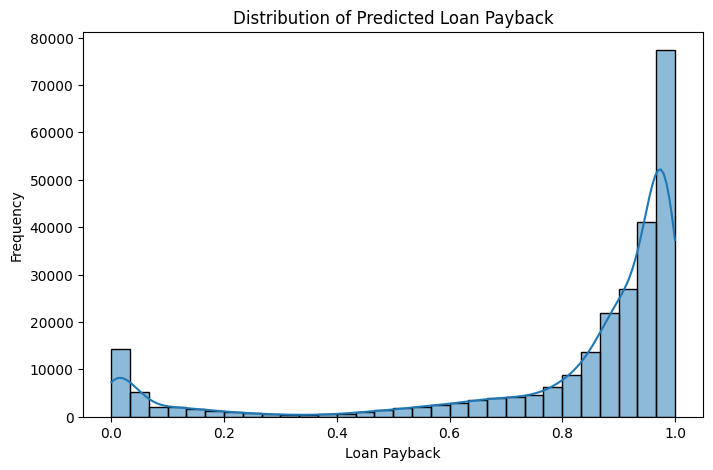

In [20]:
# --- Final Plot ---
plt.figure(figsize=(8, 5))
sns.histplot(submission['loan_paid_back'], bins=30, kde=True)
plt.title('Distribution of Predicted Loan Payback')
plt.xlabel('Loan Payback')
plt.ylabel('Frequency')
plt.show()